# The [AES](https://en.wikipedia.org/wiki/Advanced_Encryption_Standard) cipher
Consist of 4 steps:
1. Sub byte 
2. Shift Rows
3. Mix Columns
4. Add Round key
All steps applied one by one, on the same data makes the AES cipher, secure. Depending on key length, multiple rounds of said transformation steps are applied on the same data block. The goal of this notebook is to implement all 4 steps independently. And than test implementation of AES algorithm against [crypto](https://pycryptodome.readthedocs.io/en/latest/src/cipher/aes.html) library.

In [69]:
import numpy as nn
from numpy import uint8
from typing import List
from aes_commons import *
import math
from matplotlib import pyplot as plt
from dataclasses import dataclass

In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [71]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1=nn.Linear(16,16*4)
        self.fc2=nn.Linear(16*4,16*4)
        self.fc3=nn.Linear(16*4,16)
        self.dropout = torch.nn.Dropout(p=0.1, inplace=False)
        
    def forward(self,x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.fc3(x)
        output = F.sigmoid(x)
        return output
net = Net()
    

In [72]:
def bytes_to_float_array(data_block:List[uint8])->List[float]:
    result : List[float] = []
    
    for id, byte in enumerate(data_block):
        input = bin(byte)
        input = input[2:]
        input = input[::-1]
        for _ in range(8):
            result.append(0.0)

        for i, bit in enumerate(input):
            result[id * 8 + i] = float(bit)
            
    return result
print(bytes_to_float_array({uint8(6)}))

[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [73]:
import random
@dataclass()
class CryptoDataset:

    no_bytes: int # no of bytes in ciphered message
    batch_size: int
    n :int
    @staticmethod
    def from_size(no_bytes:int,batch_size:int):        
        return CryptoDataset(no_bytes=no_bytes,batch_size = batch_size)
        
    def __init__(self,  no_bytes:int, batch_size:int):
        self.no_bytes = no_bytes
        self.batch_size = batch_size
    
    def next_sub_byte(self):
        
        label : List[uint8] = []
        for _ in range(self.no_bytes) :
            label.append(uint8(random.randint(0,255)))
        
        input : List[uint8] = sub_bytes(label) 
        return (torch.FloatTensor(bytes_to_float_array(input)),torch.FloatTensor(bytes_to_float_array(label)))
    def __iter__(self):
        self.n = 0
        return self

    def __next__(self):
        if self.n < self.size:
            self.n += 1
            return self.next_sub_byte()
        else:
            raise StopIteration
        

In [74]:
def loss_function(output:List[float],label:List[float]):

    same = 0
    for o, l in zip(output,label):
        if o == l:
            same+=1
        
    return torch.tensor(1 - (same / len(input)), requires_grad=True)

In [75]:
import torch.optim as optim

criterion = nn.L1Loss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

[1,   100] loss: 0.025
[1,   200] loss: 0.025
[1,   300] loss: 0.025
[1,   400] loss: 0.025
[1,   500] loss: 0.025
[1,   600] loss: 0.025
[1,   700] loss: 0.025
[1,   800] loss: 0.025
[1,   900] loss: 0.025
[1,  1000] loss: 0.025
[2,   100] loss: 0.025
[2,   200] loss: 0.025
[2,   300] loss: 0.025
[2,   400] loss: 0.025
[2,   500] loss: 0.025
[2,   600] loss: 0.025
[2,   700] loss: 0.025
[2,   800] loss: 0.025
[2,   900] loss: 0.025
[2,  1000] loss: 0.025
[3,   100] loss: 0.025
[3,   200] loss: 0.025
[3,   300] loss: 0.025
[3,   400] loss: 0.025
[3,   500] loss: 0.025
[3,   600] loss: 0.025
[3,   700] loss: 0.025
[3,   800] loss: 0.025
[3,   900] loss: 0.025
[3,  1000] loss: 0.025
[4,   100] loss: 0.025
[4,   200] loss: 0.025
[4,   300] loss: 0.025
[4,   400] loss: 0.025
[4,   500] loss: 0.025
[4,   600] loss: 0.025
[4,   700] loss: 0.025
[4,   800] loss: 0.025
[4,   900] loss: 0.025
[4,  1000] loss: 0.024
[5,   100] loss: 0.025
[5,   200] loss: 0.024
[5,   300] loss: 0.025
[5,   400] 

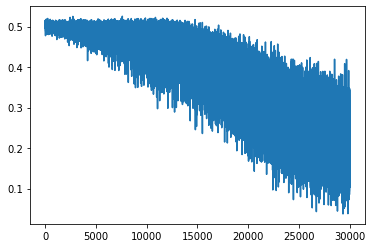

In [76]:

dataloader = CryptoDataset.from_size(2,1000)
lr = []
for epoch in range(30):  # loop over the dataset multiple times
    running_loss = 0.0
    for iteration in range(1000):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels  = dataloader.next_sub_byte() # torch.tensor([float(i)]) / 100, torch.tensor([float(i+10)]) / 100

        # inputs, labels  = inputs/ -256, labels.reshape(-1, 0) / -256

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
 
        # print statistics
        running_loss += loss.item()
        lr.append(loss.item())
        if iteration % 100 == 99:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {iteration + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
plt.plot(lr)
            

In [83]:
def diff(output:List[float],label:List[float]):

        same = 0.0
        for o, l in zip(output,label):
            same += abs(o - l)

        return same / len(output)
def radical(output:List[float])->List[int]:
    solution = []
    for o in output:
        if o >= 0.5:
            solution.append(1)
        else:
            solution.append(0)
    return solution

global_difference = 0
for index in range(10):
    inputs, labels  = dataloader.next_sub_byte() # torch.tensor([float(i)]) / 100, torch.tensor([float(i+10)]) / 100

    outputs = net(torch.FloatTensor(inputs))
    print(f"    output: {outputs.detach().numpy()}\nrad output: {radical(outputs.detach().numpy())}\n     labels: {radical(labels)}")
    
print(f"average difference in bits: {global_difference / 10_000}")

    output: [0.06105788 0.9799896  0.5596649  0.8252644  0.9925478  0.04124789
 0.02046245 0.05624417 0.40351453 0.15147857 0.3117598  0.039039
 0.97113466 0.3579192  0.9965922  0.19268061]
rad output: [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
     labels: [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
    output: [0.83182347 0.9805177  0.91134846 0.15062027 0.61015546 0.99428236
 0.3124601  0.09199485 0.64999014 0.89523196 0.15553539 0.14317463
 0.06997842 0.58894473 0.8699736  0.69623035]
rad output: [1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1]
     labels: [1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0]
    output: [0.8342213  0.94683355 0.8488094  0.6385495  0.98357475 0.32711178
 0.27356285 0.00228319 0.09704603 0.36606988 0.16608222 0.4295157
 0.99823356 0.9976891  0.161574   0.22580518]
rad output: [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]
     labels: [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]
    output: [0.3721897  0.1636907  0.08140086 0.30264097 0

In [87]:


def radical_diff(output:List[float],label:List[float]):
    output = radical(output)
    label = radical(label)
    difference = 0
    for o,l in zip(output,label):
        if o != l:
            difference+=1
    return difference

global_diff = 0
for a in range(2**8):
    for b in range(2**8):
        label = [uint8(a),uint8(b)]
        input = sub_bytes(label)
        output = net(torch.FloatTensor(bytes_to_float_array(input)))
        global_diff += radical_diff(bytes_to_float_array(label),output.detach().numpy())
print(global_diff / 2**16)

c:\I\python38\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


2.0417938232421875
